In [1]:
import numpy as np 
from main import RAW_SESSIONS, RAW_SESSIONS2, oxasl_dir, OUTROOT, anatdir_name, SUBJECTS
import analysis_scripts as ascripts
import itertools 
import nibabel
from pdb import set_trace
import matplotlib.pyplot as plt 
import sys 
import pickle
TISSUES = ['GM', 'WM']
METHODS = ['Tob', 'FAST']
cmap = np.array(plt.get_cmap('tab10').colors)


In [2]:
niiload = lambda p: nibabel.load(p).get_fdata().reshape(-1)

bin_edges, bin_cents = ascripts.make_hist_bins(5)

def loaddir(d, spc):
        
    tob =  np.stack(
        [ niiload(op.join(d, 'output_surf_pvcorr', spc, 'perfusion%s_calib.nii.gz' % t))
               for t in ['', '_wm'] ])
    fast = np.stack(
        [ niiload(op.join(d, 'output_pvcorr', spc, 'perfusion%s_calib.nii.gz' % t))
               for t in ['', '_wm'] ])
    
    non = niiload(op.join(d, 'output', spc, 'perfusion_calib.nii.gz'))
    return [ tob.T, fast.T, non.T ] 

def loadpvs(d):
    tob =  np.stack(
        [ niiload(op.join(d, 'surf_pvs', '%s.nii.gz' % t))
               for t in ['GM', 'WM'] ])
    fast = np.stack(
        [ niiload(op.join(d, 'structural', '%s_pv_asl.nii.gz' % t))
               for t in ['gm', 'wm'] ])
    
#     n = niiload(op.join(d, 'output', 'native', 'perfusion_calib.nii.gz'))
    return [ tob.T,fast.T ] 

def loadmask(d): 
    paths = [ op.join(d, 'surf_pvs', '%s.nii.gz' % t)
               for t in TISSUES ] 
    gm,wm = [ niiload(p) for p in paths ]
    return np.logical_or(gm > 0, wm > 0)

def calc_voxel_COV(a,b):
    return (np.abs(a-b)).std() / ((0.5*(a+b)).mean())

# def calc_region_COV(a,b)

def load_struct_pvs(sub):
    tob = np.stack(
        [ niiload(op.join(OUTROOT, str(sub), 'stuct_pvs', '%s.nii.gz') % t)
               for t in ['GM', 'WM'] ])

    fast = np.stack(
        [ niiload(op.join(anatdir_name(sub), 'T1_fast_pve_%d.nii.gz' % t))
               for t in [1,2]] )

    return [ tob.T,fast.T ] 


def gen_path_dict(state, mode):
    path_dict = {}
    for k in range(1,8): 
        paths = []
        for idx,sess in enumerate(RAW_SESSIONS[k]): 
            pth = oxasl_dir(1, k, sess, state, False)
            if (mode == 'all'):
                paths.append(pth)
                if (k in RAW_SESSIONS2) and (sess in RAW_SESSIONS2[k]):
                    paths.append(oxasl_dir(2, k, sess, state, False))        
            elif mode == 'sess':
                if (k in RAW_SESSIONS2) and (sess in RAW_SESSIONS2[k]):
                    paths.append(pth)
                    paths.append(oxasl_dir(2, k, sess, state, False))  
            else: 
                if sess == "A":
                    paths.append(pth) 
                    continue 
                elif idx == 0: 
                    paths.append(None)
                    continue 
                if (mode == 'week') and (sess == "B"):
                    paths.append(pth)
                if (mode == 'month') and (sess == "C"):
                    paths.append(pth)         
        if len(paths) > 1: 
            path_dict[k] = paths
        else: 
            path_dict[k] = []        
    return path_dict

RESTS = lambda mode: gen_path_dict('rest', mode)
TASKS = lambda mode: gen_path_dict('task', mode)

In [4]:
def calc_vox_covs(path_dict, spc, pv=False):
    
    if not pv: 
        out = ascripts.x_array(coords={'sub': list(path_dict.keys()), 
                                       'run': range( max([ len(path_dict[k]) for k in path_dict.keys() ]) -1 ), 
                                       'tiss': TISSUES, 
                                       'meth': METHODS,
                                       'PVC': ['no PVC', 'PVC']})
    else: 
        out = ascripts.x_array(coords={'sub': list(path_dict.keys()), 
                               'run': range( max([ len(path_dict[k]) for k in path_dict.keys() ]) -1 ), 
                               'tiss': TISSUES, 
                               'meth': METHODS,
                               'PVC': ['no PVC', 'PVC'],
                               'bin': range(bin_cents.size)})

    for sub,dirs in path_dict.items(): 
        for ridx,rdir in enumerate(dirs): 
            if rdir is None: continue 
            
            if ridx == 0: 
                tobref,fastref,nonref = loaddir(rdir, spc)
                if spc == 'native':
                    tpvs,fpvs = loadpvs(rdir)
                elif spc == 'struct':
                    tpvs,fpvs = load_struct_pvs(sub)
                
                tbinned,fbinned = [ np.digitize(x,bin_edges,True) - 1 for x in [tpvs,fpvs] ]
                mask = tpvs.any(1)   

            else:
                to,fast,non = loaddir(rdir, spc)

                for tidx,tiss in enumerate(TISSUES):
                    if not pv: 
                        out.loc[sub,ridx-1,tiss,METHODS[0],'PVC'] = calc_voxel_COV(to[mask,tidx], tobref[mask,tidx])
                        out.loc[sub,ridx-1,tiss,METHODS[1],'PVC'] = calc_voxel_COV(fast[mask,tidx], fastref[mask,tidx])
                        out.loc[sub,ridx-1,tiss,:,'no PVC'] = calc_voxel_COV(non[mask], nonref[mask])
                            
                    else: 
                        for bidx in range(bin_cents.size):
                            for meth,data,ref,bins in zip(METHODS,[to,fast],[tobref,fastref],[tbinned,fbinned]):
                                fltr = np.flatnonzero(bins[mask,tidx]==bidx)
                                out.loc[sub,ridx-1,tiss,meth,'PVC',bidx] = calc_voxel_COV(data[mask,tidx][fltr], 
                                                                                      ref[mask,tidx][fltr])

                                out.loc[sub,ridx-1,tiss,meth,'no PVC',bidx] = calc_voxel_COV(non[mask][fltr], 
                                                                                      nonref[mask][fltr])
                            

    return out 
        
def calc_cbf(path_dict, spc, pv=False):
    
    if pv: 
        out = ascripts.x_array(coords={'sub': list(path_dict.keys()), 
                                       'run': range( max([ len(path_dict[k]) for k in path_dict.keys() ]) ),
                                       'tiss': TISSUES, 
                                       'meth': METHODS,
                                       'PVC': ['no PVC', 'PVC'],
                                       'bin': range(bin_cents.size), 
                                       'metric': ['mean', 'std'] })
    else:
         out = ascripts.x_array(coords={'sub': list(path_dict.keys()), 
                                       'run': range( max([ len(path_dict[k]) for k in path_dict.keys() ]) ),
                                       'tiss': TISSUES, 
                                       'meth': METHODS,
                                       'PVC': ['no PVC', 'PVC'],
                                       'metric': ['mean', 'std'] })
    
    for sub,dirs in path_dict.items(): 
        for ridx,rdir in enumerate(dirs): 
            if rdir is None: continue 
                
            tobcbf,fastcbf,noncbf = loaddir(rdir, spc)
            
            if spc == 'native':
                tpvs,fpvs = loadpvs(rdir)
            elif spc == 'struct':
                tpvs,fpvs = load_struct_pvs(sub)
                
            tbinned,fbinned = [ np.digitize(x,bin_edges,True) - 1 for x in [tpvs,fpvs] ]
            mask = tpvs.any(1)   
            
            for tidx,tiss in enumerate(TISSUES):
                for bins,data,meth in zip([tbinned,fbinned], [tobcbf,fastcbf], METHODS):
                    if pv: 
                        for bidx in range(bin_cents.size):
                            fltr = np.flatnonzero(bins[mask,tidx]==bidx)
                            d = data[mask,tidx][fltr]
                            if d.any():
                                out.loc[sub,ridx,tiss,meth,'PVC',bidx,:] = [d.mean(), d.std()]
                            d = noncbf[mask][fltr]
                            if d.any():
                                out.loc[sub,ridx,tiss,meth,'no PVC',bidx,:] = [d.mean(), d.std()]
                    else: 
                        d = data[mask,tidx]
                        out.loc[sub,ridx,tiss,meth,'PVC',:] = [d.mean(), d.std()]
                        d = noncbf[mask]
                        out.loc[sub,ridx,tiss,meth,'no PVC',:] = [d.mean(), d.std()]
            
    return out 
    

In [10]:
keys = ['sess', 'week', 'month', 'all']

In [ ]:
STRUCT_CBF_PVS = {k: calc_cbf(RESTS(k), 'struct', True) for k in keys }

In [ ]:
STRUCT_VCOV_PVS = {k: calc_vox_covs(RESTS(k), 'struct', True) for k in keys }

In [ ]:
NATIVE_CBF_PVS = {k: calc_cbf(RESTS(k), 'native', True) for k in keys }

In [11]:
if not sys.platform.startswith('darwin'):
    with open('data.pkl', 'wb') as f: 
        pickle.dump([STRUCT_CBF_PVS, STRUCT_VCOV_PVS, NATIVE_CBF_PVS], f)
        
else: 
    with open('data.pkl', 'rb') as f: 
        [STRUCT_CBF_PVS, STRUCT_VCOV_PVS, NATIVE_CBF_PVS] = pickle.load(f)

### Voxel-wise and regional CoV (>80% GM ROI, structural space)

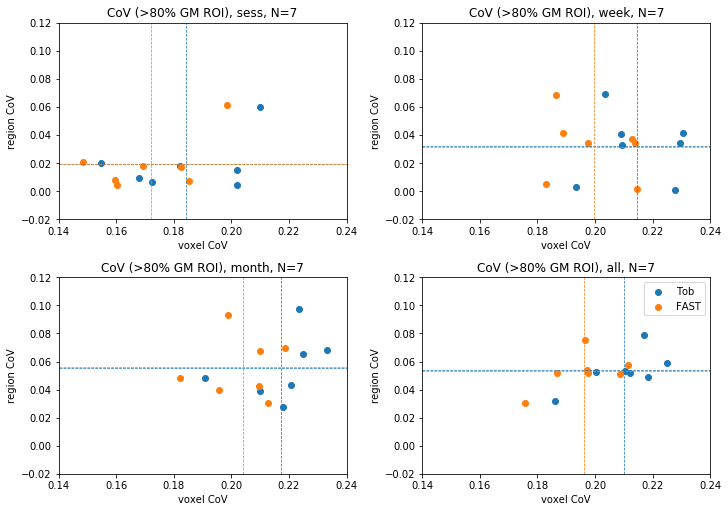

In [21]:
fig,axes = plt.subplots(2, 2, constrained_layout=True)
fig.set_size_inches(10,7)
xlims = (0.14, 0.24)
ylims = (-0.02, 0.12)

for key,ax in zip(keys, axes.flat):

    meth_means = np.empty((2,2))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    for midx,meth in enumerate(METHODS):
        vc = np.ma.masked_less(STRUCT_VCOV_PVS[key].loc[:,:,'GM',meth,'PVC',bin_cents.size-1], 1e-9)
        vc = vc.mean(1)
        rc = np.ma.masked_less(STRUCT_CBF_PVS[key].loc[:,:,'GM',meth,'PVC',bin_cents.size-1,'mean'], 1e-9)
        rc = rc.std(1) / rc.mean(1)
        ax.scatter(vc, np.abs(rc), c=cmap[midx,None], label=meth)
        meth_means[midx,:] = [vc.mean(0), rc.mean(0)]

    ax.set_title('CoV (>80%% GM ROI), %s, N=%d' % (key, rc.shape[0]))
    ax.set_xlabel('voxel CoV')
    ax.set_ylabel('region CoV')
    for midx in range(2):
        ax.plot(np.tile(meth_means[midx,0],2), ylims, linestyle='--', c=cmap[midx,:], linewidth=0.75)
        ax.plot(xlims, np.tile(meth_means[midx,1], 2), linestyle='--', c=cmap[midx,:], linewidth=0.75)

ax.legend()
plt.show()

### Mean CBF (>80% GM ROI, native space)

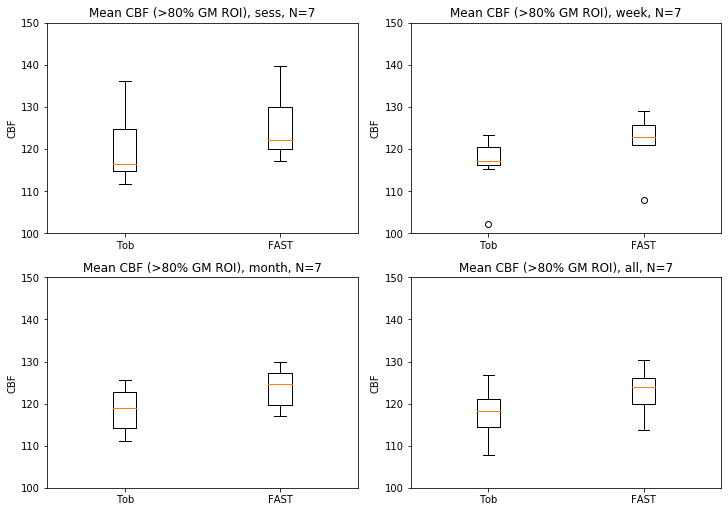

In [23]:
fig,axes = plt.subplots(2,2, constrained_layout=True)
fig.set_size_inches(10,7)
lims = (100,150)

for key,ax in zip(keys, axes.flat):
    ax.set_ylabel('CBF')
    ax.set_ylim(lims)

    # for midx,meth in enumerate(METHODS[:2]):
    x = np.ma.masked_less(NATIVE_CBF_PVS[key].loc[:,:,'GM',:,'PVC',3,'mean'], 1e-9)
    x = np.ma.masked_less(x.mean(1), 1e-9)
    ax.boxplot(x, labels=METHODS)
    ax.set_title('Mean CBF (>80%% GM ROI), %s, N=%d' % (key, x.shape[0]))

plt.show()

### Mean CBF (>80% GM ROI, native space)

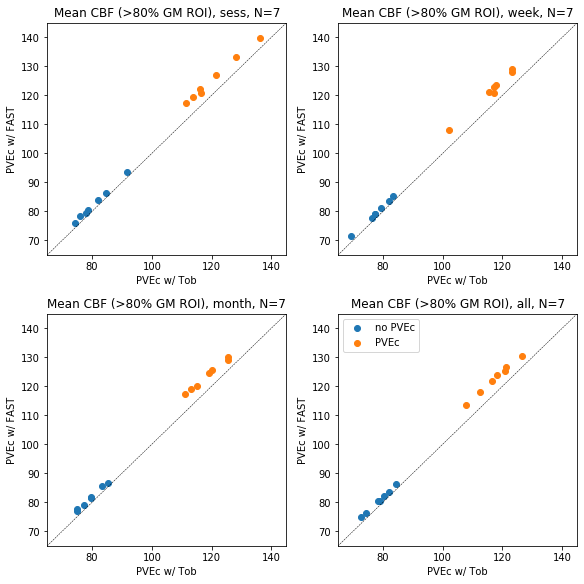

In [31]:
fig,axes = plt.subplots(2,2, constrained_layout=True)
fig.set_size_inches(8,8)
lims = (65,145)

for key,ax in zip(keys, axes.flat):
    x = np.ma.masked_less(NATIVE_CBF_PVS[key].loc[:,:,'GM',:,:,3,'mean'], 1e-9)
    x = np.ma.masked_less(x.mean(1), 1e-9)
    ax.plot(lims,lims, 'k--', linewidth=0.5)
    ax.scatter(x[:,0,0], x[:,1,0], label='no PVEc')
    ax.scatter(x[:,0,1], x[:,1,1], label='PVEc')
    
    ax.set_title('Mean CBF (>80%% GM ROI), %s, N=%d' % (key,x.shape[0]))
    ax.set_xlabel('PVEc w/ Tob')
    ax.set_ylabel('PVEc w/ FAST')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
# [ ax.set_aspect('equal', 'box') for ax in axes.flat ] 
ax.legend()
plt.show()

### Inter-subject mean CBF within PV ROIs (native space)

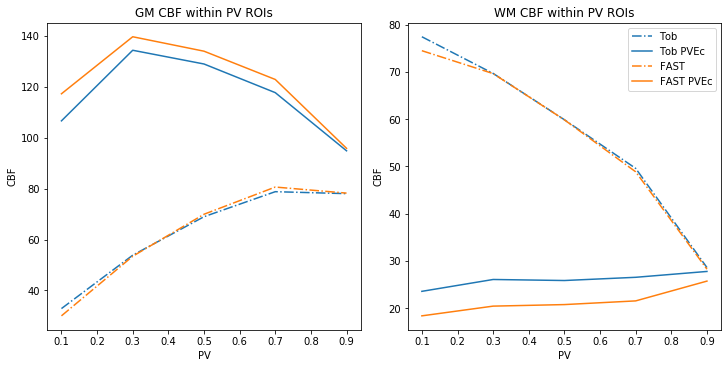

In [27]:
fig, axes = plt.subplots(1,2,constrained_layout=True)
fig.set_size_inches(10,5)

for tiss,ax in zip(TISSUES, axes.flat):
    ax.set_xlabel('PV')
    ax.set_ylabel('CBF')
    for midx,meth in enumerate(METHODS):
        y1 = np.ma.masked_less(NATIVE_CBF_PVS['all'].loc[:,:,tiss,meth,:,:,'mean'], 1e-9)
        y1 = y1.mean(1).mean(0)
        ax.plot(bin_cents, y1[0,:], linestyle='-.', c=cmap[midx,:], label=meth)
        ax.plot(bin_cents, y1[1,:], c=cmap[midx,:], label=meth+' PVEc')
        ax.set_title('%s CBF within PV ROIs' % (tiss))

ax.legend()
plt.show()

### Within-acquisition CBF variability (GM ROIs, native space)

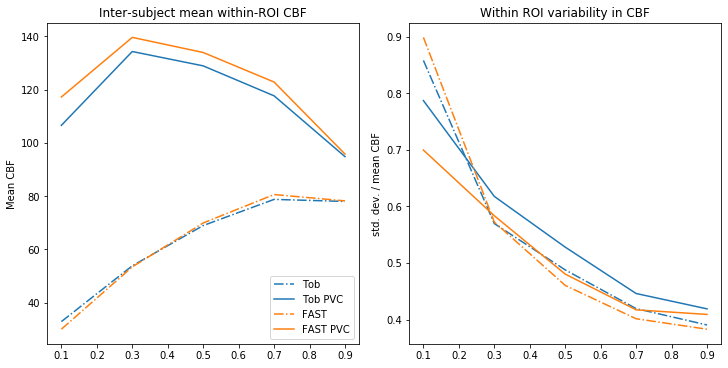

In [28]:
fig, axes = plt.subplots(1,2,constrained_layout=True)
fig.set_size_inches(10,5)

for midx,meth in enumerate(METHODS):
    ax.set_xlabel('PV')
    y1 = NATIVE_CBF_PVS['all'].loc[:,:,'GM',meth,:,:,'mean']
    y1 = np.ma.masked_less(y1, 1e-9).mean(1).mean(0)
    
    y2 = NATIVE_CBF_PVS['all'].loc[:,:,'GM',meth,:,:,'std']
    y2 = np.ma.masked_less(y2, 1e-9).mean(1).mean(0)
    y2 = y2 / y1 
    
    axes[0].plot(bin_cents, y1[0,:], c=cmap[midx,:], label=meth, linestyle='-.')
    axes[1].plot(bin_cents, y2[0,:], c=cmap[midx,:], label=meth, linestyle='-.') 
    axes[0].plot(bin_cents, y1[1,:], c=cmap[midx,:], label=meth+' PVC')
    axes[1].plot(bin_cents, y2[1,:], c=cmap[midx,:], label=meth+' PVC')
    
axes[0].set_title('Inter-subject mean within-ROI CBF')
axes[0].set_ylabel('Mean CBF')
axes[1].set_title('Within ROI variability in CBF')
axes[1].set_ylabel('std. dev. / mean CBF')
axes[0].legend()
plt.show()

### Voxel-wise CoV within GM ROIs (structural space)

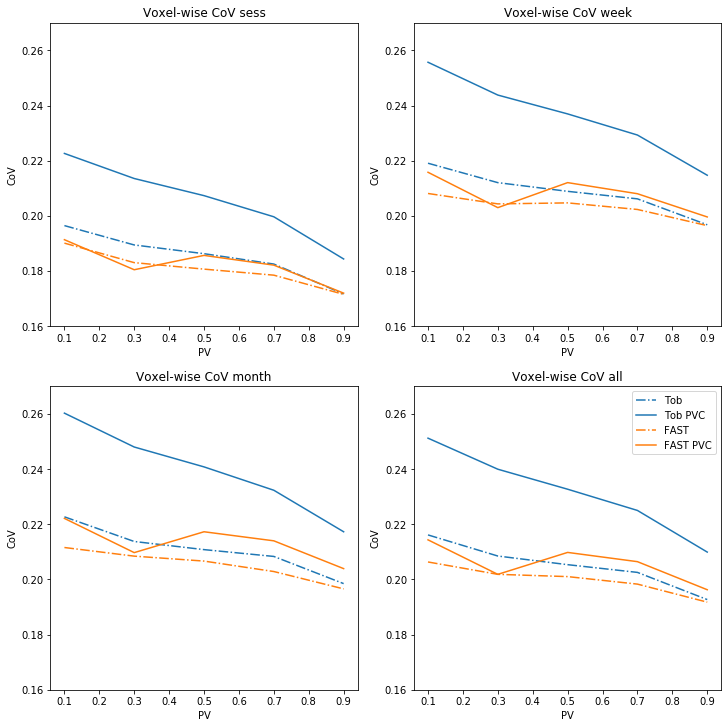

In [30]:
fig,axes = plt.subplots(2,2, constrained_layout=True)
fig.set_size_inches(10,10)
lims = (0.16,0.27)

for key, ax in zip(keys, axes.flat):
    ax.set_ylim(lims)
    for midx,meth in enumerate(METHODS):
        vc = np.ma.masked_less(STRUCT_VCOV_PVS[key].loc[:,:,'GM',meth,:,:], 1e-9)
        vc = vc.mean(1).mean(0)
        ax.plot(bin_cents, vc[0,:], label=meth, linestyle='-.', c=cmap[midx,:])
        ax.plot(bin_cents, vc[1,:], label=meth+' PVC', c=cmap[midx,:])
        ax.set_title('Voxel-wise CoV %s' % (key))
        ax.set_ylabel('CoV')
        ax.set_xlabel('PV')

ax.legend()
plt.show()